In [29]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
# import missingno as mgno


In [4]:
NSCH19 = pd.read_sas("data/nsch_2019e_topical.sas7bdat")
#NSCH22 = pd.read_sas("data/nsch_2022e_topical.sas7bdat")

In [5]:
NSCH19.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29433 entries, 0 to 29432
Columns: 448 entries, FIPSST to HOUSE_GEN
dtypes: float64(444), object(4)
memory usage: 100.6+ MB


In [6]:
NSCH19.head()

,FIPSST,STRATUM,HHID,FORMTYPE,TOTKIDS_R,TENURE,HHLANGUAGE,SC_AGE_YEARS,SC_SEX,K2Q35A_1_YEARS,...,FRSTSOLIDS_MO_S,BREASTFEDEND_DAY_S,BREASTFEDEND_WK_S,FRSTFORMULA_DAY_S,FRSTFORMULA_WK_S,FRSTSOLIDS_DAY_S,FRSTSOLIDS_WK_S,A1_BORN,A2_BORN,HOUSE_GEN
0,b'51',b'2A',b'19000001',b'T1',1.0,1.0,1.0,1.0,2.0,NaN,...,6.0,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,3.0
1,b'21',b'1',b'19000002',b'T3',1.0,1.0,1.0,15.0,1.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,3.0
2,b'13',b'1',b'19000003',b'T2',1.0,1.0,1.0,6.0,2.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,3.0
3,b'47',b'1',b'19000006',b'T2',3.0,1.0,1.0,10.0,1.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,3.0
4,b'18',b'1',b'19000010',b'T1',3.0,1.0,1.0,0.0,2.0,NaN,...,1.0,NaN,NaN,NaN,NaN,NaN,NaN,2.0,2.0,2.0


In [47]:
geo_features = ['FIPSST']
## K7Q02R_R is number of days missed in school because of illness or injury.
## Responses are binned in intervals of 3 days, with 1 meaning no missed days, 5 meaning 11+ days, 6 meaning no enrolled
## in school
edu_features = 'K7Q02R_R'
med_features = ['AVAILABLE', 'APPOINTMENT', 'ISSUECOST', 
                'NOTELIG', 'NOTOPEN', 'TRANSPORTCC',
                'CURRCOV', 
                'HOWMUCH', #how much was paid for health care
                'INSTYPE', #public/ priv/ none
                'K3Q04_R', #any type of health ins
                'K12Q12', #govt assistance plan (yes/ no)
                'K3Q21B', 'K3Q20', 'K3Q25', #cost reasonable, needs covered, allowed to see providers
                'K4Q01', #is there place can take child when they are sick
                'K4Q24_R', 'K4Q26', #how difficult to get specialist care
                'K4Q27', #Was there any time when child needed health care but did not receive?
                'S4Q01', #did this child see a doctor
                'K5Q31_R', 'K5Q32' #satisfactory communication from doctor to school
                ]           

features = geo_features + [edu_features] + med_features

In [96]:
def FIPS_to_State(data, state='both'):
    #This function specifically includes a column corresponding
    #to either the state abbreviation if state='abbr' or
    #the full state name if state='full' or both='both'.  Note that this is specifically written
    #for NSCH data which names their FIPS column FIPSST.  This also requires the
    #FIPS_State.csv file which translates between FIPS and State.  

    #Also note: this function changes the FIP code to an integer from a byte string.

    FIPS_state = pd.read_csv('data/FIPS_State.csv')
    FIPS_state['FIPSST'] = FIPS_state.FIPS

    data.FIPSST = data.FIPSST.apply(int)

    if state == 'abbr':
        data = data.merge(FIPS_state[['FIPSST', 'ABBR']], on='FIPSST')

    if state == 'full':
        data = data.merge(FIPS_state[['FIPSST', 'STATE']], on='FIPSST') 

    if state == 'both':
        data = data.merge(FIPS_state[['FIPSST', 'STATE', 'ABBR']], on='FIPSST')                

    return data


In [50]:
numcols = NSCH19.select_dtypes(['number'])
cols_list1 = numcols.iloc[:, [i for i in range(0,49)]]
features1 = [columns for columns in cols_list1]
#features1
#cols_list1


In [48]:
edu_features

'K7Q02R_R'

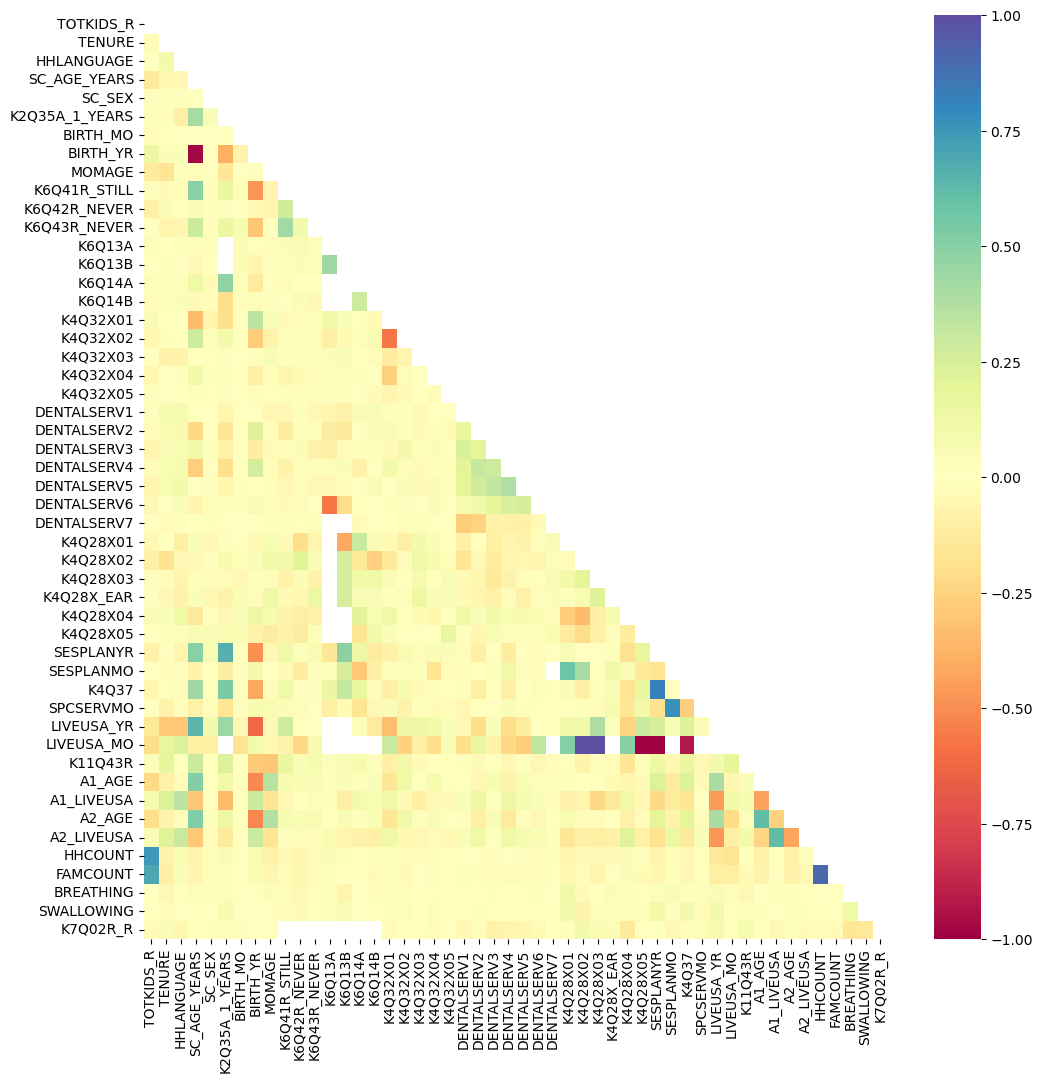

In [55]:
# mgno.heatmap(NSCH19[features])
corr1 = NSCH19[features1 + [edu_features]].corr()
mask = np.triu(np.ones_like(corr1, dtype=bool))
plt.figure(figsize=(12, 12))
sns.heatmap(corr1, mask=mask, annot=False, vmin=-1, vmax=1, fmt=".2f", cmap="Spectral")
plt.show()

In [98]:
NSCH19 = FIPS_to_State(NSCH19)

In [99]:
## This will list the percent of data which is missing by state
## I borrowed the code from https://stackoverflow.com/questions/46106954/using-isnull-and-groupby-on-a-pandas-dataframe

NSCH19_nullByState = NSCH19[features].isnull().groupby(NSCH19['ABBR']).mean()
NSCH19_nullByState.sort_values(by="K7Q02R_R", ascending=False)


,FIPSST,K7Q02R_R,AVAILABLE,APPOINTMENT,ISSUECOST,NOTELIG,NOTOPEN,TRANSPORTCC,CURRCOV,HOWMUCH,...,K3Q21B,K3Q20,K3Q25,K4Q01,K4Q24_R,K4Q26,K4Q27,S4Q01,K5Q31_R,K5Q32
ABBR,,,,,,,,,,,,,,,,,,,,,
DC,0.0,0.434256,0.979239,0.979239,0.979239,0.979239,0.979239,0.979239,0.005190,0.006920,...,0.200692,0.036332,0.202422,0.005190,0.010381,0.804498,0.001730,0.003460,0.067474,0.863322
ND,0.0,0.340463,0.971480,0.971480,0.971480,0.971480,0.971480,0.971480,0.005348,0.010695,...,0.144385,0.046346,0.144385,0.001783,0.008913,0.843137,0.007130,0.001783,0.155080,0.935829
KY,0.0,0.317544,0.980702,0.980702,0.980702,0.980702,0.980702,0.980702,0.001754,0.012281,...,0.303509,0.033333,0.301754,0.003509,0.005263,0.826316,0.003509,0.000000,0.115789,0.908772
MN,0.0,0.316081,0.963031,0.963031,0.963031,0.963031,0.963031,0.963031,0.000000,0.005545,...,0.190388,0.044362,0.188540,0.000000,0.003697,0.857671,0.000000,0.000000,0.133087,0.911275
NH,0.0,0.315705,0.977564,0.977564,0.977564,0.977564,0.977564,0.977564,0.001603,0.012821,...,0.192308,0.032051,0.195513,0.000000,0.001603,0.770833,0.000000,0.000000,0.067308,0.863782
DE,0.0,0.309315,0.977153,0.977153,0.977153,0.977153,0.977153,0.977153,0.007030,0.015817,...,0.251318,0.049209,0.247803,0.005272,0.015817,0.811951,0.007030,0.000000,0.121265,0.887522
MO,0.0,0.307200,0.969600,0.969600,0.969600,0.969600,0.969600,0.969600,0.004800,0.008000,...,0.244800,0.068800,0.238400,0.001600,0.011200,0.820800,0.001600,0.000000,0.137600,0.904000
LA,0.0,0.306349,0.979365,0.979365,0.979365,0.979365,0.979365,0.979365,0.003175,0.007937,...,0.355556,0.058730,0.355556,0.001587,0.004762,0.811111,0.004762,0.001587,0.131746,0.903175
CA,0.0,0.303293,0.970537,0.970537,0.970537,0.970537,0.970537,0.970537,0.000000,0.013865,...,0.275563,0.038128,0.273830,0.005199,0.001733,0.880416,0.005199,0.000000,0.135182,0.935875


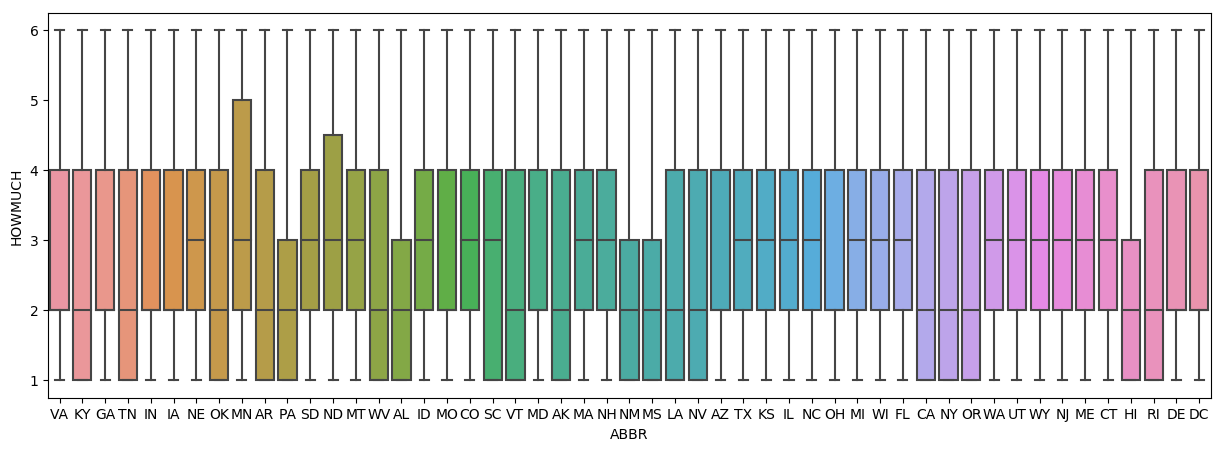

In [100]:
plt.figure(figsize=(15,5))
sns.boxplot(data = NSCH19, y=NSCH19['HOWMUCH'], x='ABBR')
plt.show()